In [69]:
# standard library imports
import os
import sys
from collections import Counter

# pandas, seaborn etc.
import seaborn as sns
import sklearn 
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np

# sklearn outlier models
from sklearn.neighbors import NearestNeighbors
# from sklearn.neighbors import LocalOutlierFactor # Use pyod's wrapper
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

# other sklearn functions
from sklearn.decomposition import PCA
from sklearn.covariance import MinCovDet, EmpiricalCovariance
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import scale as preproc_scale
from sklearn.manifold import TSNE

# pyod
import pyod
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.pca import PCA as pyod_PCA
from pyod.models.iforest import IForest

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sys.path.append("..") #to enable importing from ../outlierutils
from outlierutils import median_imputation, LabelSubmitter, plot_outlier_scores, plot_top_N
url = "https://unsupervised-label-api-pg.herokuapp.com/"


In [35]:
data_path = '../bigdata/'
x_kdd = pd.read_pickle(os.path.join(data_path, 'x_kdd_prepared.pkl'))
y_kdd = pd.read_pickle(os.path.join(data_path, 'y_kdd_prepared.pkl'))

In [13]:
x_kdd.describe()

,protocol_type = udp,protocol_type = tcp,protocol_type = icmp,service = private,service = domain_u,service = http,service = smtp,service = ftp_data,service = ftp,service = eco_i,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,48113.000000,48113.000000,48113.000000,48113.000000,48113.000000,48113.000000,48113.000000,48113.000000,48113.000000,48113.000000,...,48113.000000,48113.000000,48113.000000,48113.000000,48113.000000,48113.000000,48113.000000,48113.000000,48113.000000,48113.000000
mean,0.078773,0.915428,0.005799,0.023382,0.054455,0.812130,0.066614,0.022031,0.002744,0.001018,...,0.550762,0.886861,0.933777,0.013689,0.080444,0.019695,0.003301,0.002434,0.004722,0.002530
std,0.269387,0.278246,0.075930,0.151116,0.226916,0.390613,0.249355,0.146787,0.052307,0.031897,...,0.401953,0.257863,0.198722,0.075218,0.203149,0.035692,0.048284,0.044497,0.052027,0.042909
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.133333,0.984314,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.517647,1.000000,1.000000,0.000000,0.010000,0.010000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,0.040000,0.030000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


,N_submitted,N_positives_found,precision
admin,0,0,NaN
steffen,0,0,NaN
alessandro,0,0,NaN
theo,0,0,NaN
giulio,0,0,NaN
ernst,0,0,NaN
test,0,0,NaN


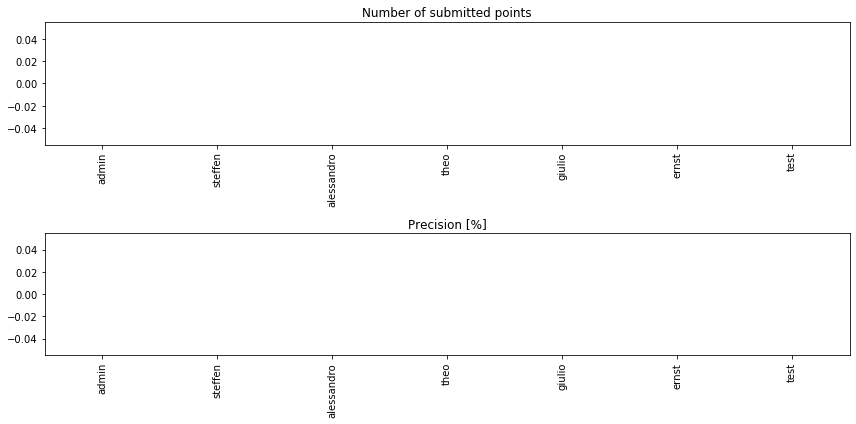

In [14]:
ls_remote.get_statistics(endpoint='kdd')

## KNN

In [15]:
# train kNN detector
n_neighbours = 10

clf = KNN(method='median', n_neighbors=n_neighbours)
clf.fit(x_kdd)
# get the prediction label and outlier scores of the training data


In [17]:
knn_labels = clf.labels_  # binary labels (0: inliers, 1: outliers)
knn_scores = clf.decision_scores_  # raw outlier scores

## LOF

In [28]:
n_neighbours = 10
lof = LOF(n_neighbors=n_neighbours, contamination=0.01)
lof.fit(x_kdd)
lof_scores = lof.decision_scores_  # raw outlier scores

## iForest

In [29]:
ifo = IForest(n_estimators=100, max_samples=1024, random_state=1, contamination=0.01, behaviour='new')
ifo.fit(x_kdd)
# NB: in contradiction to the documentation, there is no .decision_scores_ attribute for iForest
isof_scores = ifo.decision_scores_ #ifo.decision_function(x_pen) 

## Autoencoder

In [24]:
clf = AutoEncoder(
    hidden_neurons=[10, 8, 10],
    hidden_activation='elu',
    output_activation='linear',
    optimizer='adam',
    epochs=5,
    batch_size=16,
    dropout_rate=0.0,
    l2_regularizer=0.0,
    validation_size=0.1,
    preprocessing=False, #NB: this uses sklearn's StandardScaler
    verbose=1,
    random_state=1,
    contamination=0.1,
)
clf.fit(x_kdd)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 79)                6320      
_________________________________________________________________
dropout_6 (Dropout)          (None, 79)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 79)                6320      
_________________________________________________________________
dropout_7 (Dropout)          (None, 79)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                800       
_________________________________________________________________
dropout_8 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                

AutoEncoder(batch_size=16, contamination=0.1, dropout_rate=0.0, epochs=5,
      hidden_activation='elu', hidden_neurons=[10, 8, 10],
      l2_regularizer=0.0,
      loss=<function mean_squared_error at 0x7fec350711e0>,
      optimizer='adam', output_activation='linear', preprocessing=False,
      random_state=1, validation_size=0.1, verbose=1)

In [25]:
autoenc_scores = clf.decision_scores_  # raw outlier scores



## Compare with pairwise scatterplots

In [30]:
scores_df = pd.DataFrame()
scores_df['knn_scores'] = knn_scores
scores_df['lof_scores'] = lof_scores
scores_df['isof_scores'] = isof_scores
scores_df['autoenc_scores'] = autoenc_scores



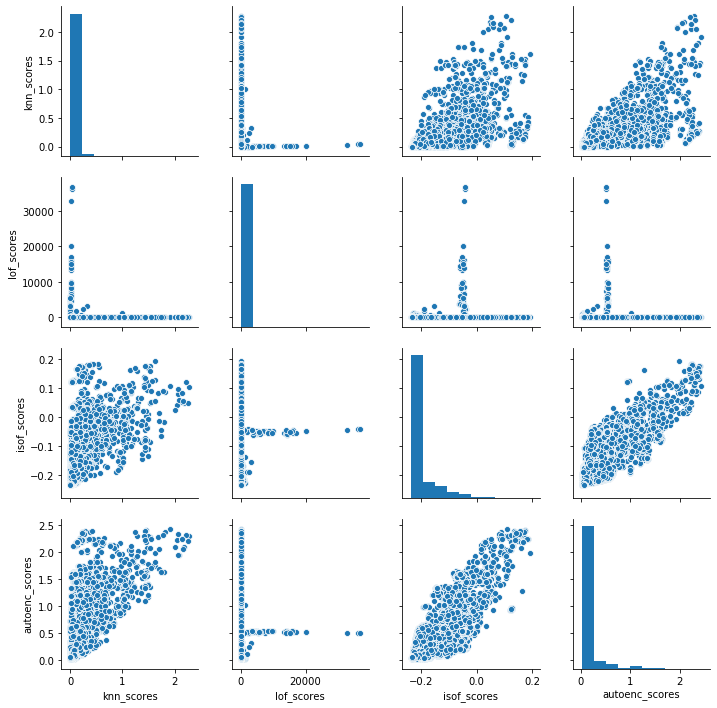

In [31]:
sns.pairplot(scores_df);

In [89]:
ls_remote = LabelSubmitter(username='ernst', 
                           password='2718_', 
                           url=url)
ls_remote.get_jwt_token()

In [90]:
isof_top1000 = np.argsort(isof_scores)[::-1][:1000]
knn_top1000 = np.argsort(knn_scores)[::-1][:1000]

In [61]:
ls_remote.post_predictions(idx=isof_top1000, endpoint='kdd')

submitted 0 new points
number of positives in submission: 162
precision of submission: 16.20%


,N_submitted,N_positives_found,precision
admin,0.0,0.0,NaN
steffen,0.0,0.0,NaN
alessandro,0.0,0.0,NaN
theo,1000.0,4.0,0.400000
giulio,0.0,0.0,NaN
ernst,1573.0,186.0,11.824539
test,0.0,0.0,NaN
tim,0.0,0.0,NaN
christian,0.0,0.0,NaN
alex,0.0,0.0,NaN


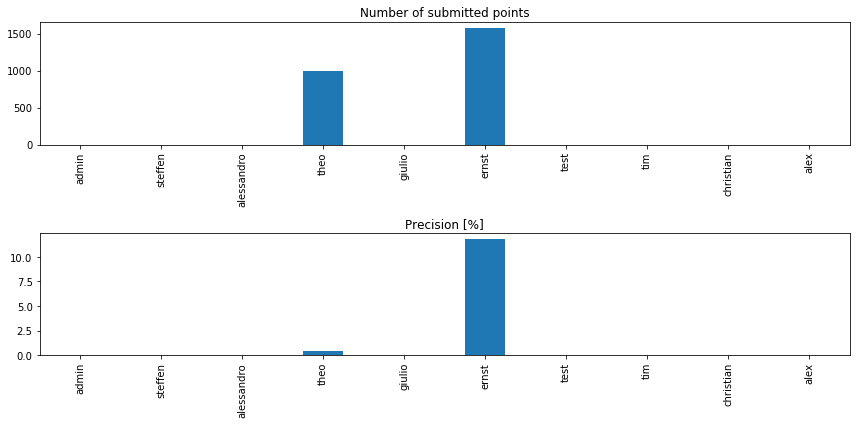

In [106]:
ls_remote.get_statistics(endpoint='kdd')

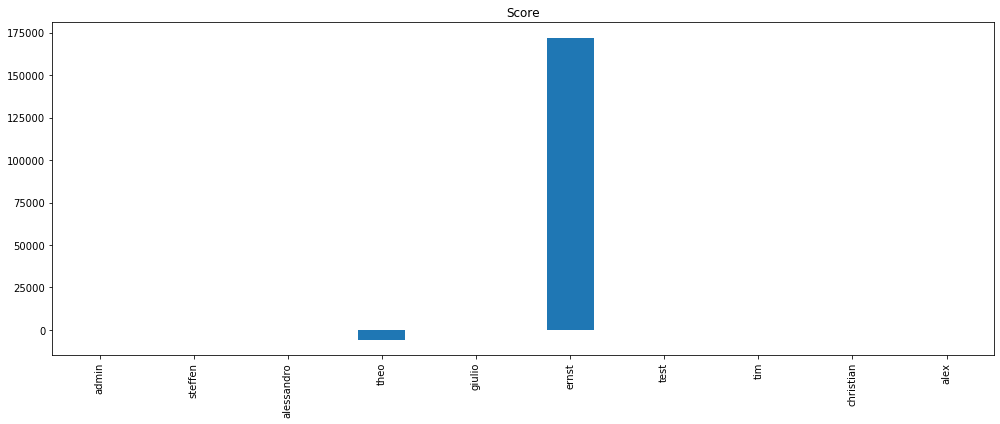

In [105]:
stats = ls_remote.get_scores(endpoint='kdd')

In [102]:
ls_theo = LabelSubmitter(username='theo', 
                           password='2718_', 
                           url=url)
ls_theo.get_jwt_token()

In [103]:
random_guess = np.random.choice(len(x_kdd), size=1000, replace=False)

In [104]:
ls_theo.post_predictions(idx=random_guess, endpoint='kdd')

submitted 1000 new points
number of positives in submission: 4
precision of submission: 0.40%


In [20]:
ls_admin = LabelSubmitter(username='admin', 
                           password='xxx', 
                           url=url)
ls_admin.get_jwt_token()
res = ls_admin.delete_labels(username='ernst', endpoint='kdd')

pass iknowwhatiamdoing=True to execute this


In [65]:
y_kdd.mean() * 100


0.41568806767401745

In [ ]:
ls_remote.post_predictions(idx=np.array([1, 2, 3, 10]), endpoint='kdd')
ls_remote.get_labels(endpoint='kdd')